In [49]:
#!pip install pandas scikit-learn sentence-transformers ipywidgets tqdm


Sample Data
    ↓
Clean Text
    ↓
Generate Embeddings
    ↓
Cluster Embeddings
    ↓
Evaluate Clusters
    ↓
Merge Low-Purity Clusters
    ↓
Final Results


In [50]:
# STEP 1: Imports
import pandas as pd
import re
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from tqdm import tqdm

In [51]:
# STEP 2: maximize column width for better readability
pd.set_option('display.max_colwidth', None)

In [52]:
# STEP 2: Read CSV
df = pd.read_csv("sample_data_redacted.csv")  # upload file

In [53]:
# Check dictinct values in 'Categorisation' column
distinct_values = df['Categorisation'].dropna().unique()
print(distinct_values)
print(f"Total distinct values: {len(distinct_values)}")

['FMPS Replaced ' 'Faulty FMPS units causing power issues (MRN Required)'
 'Temp Fix ' 'DPU Replaced' 'Faulty FMPS units causing power issues'
 'Rectifier Issue (Resolved)' 'Replaced Battery' 'DPU Replaced '
 'DPU And Additional Equipment Replaced' 'AC Mains Issues (Electrician)'
 'CB Reset' 'Third Party Power ' 'Tech Not Skilled ']
Total distinct values: 13


In [54]:
# STEP 3: Clean and Standardize closure_summary_alt
def clean_text(text):
    text = str(text).lower() # lowercasing
    text = re.sub(r'\s+', ' ', text) # remove extra space
    text = re.sub(r'[^\w\s]', '', text)  # remove punctuation
    return text.strip()

df['standardized_summary'] = df['closure_summary_alt'].fillna("").apply(clean_text)

# STEP 4: Generate Embeddings
model = SentenceTransformer("all-MiniLM-L6-v2")

print("Generating embeddings...")
embeddings = model.encode(df['standardized_summary'].tolist(), show_progress_bar=True)
embeddings = normalize(embeddings)

Generating embeddings...


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

In [55]:
# SentenceTransformer is a good choice because it provides state-of-the-art sentence embeddings using pre-trained transformer models (like BERT, RoBERTa, etc.).
# These embeddings capture semantic meaning, allowing similar sentences to have similar vector representations.
# This is especially useful for clustering, semantic search, and other NLP tasks where understanding sentence meaning is important.
# Additionally, SentenceTransformer is easy to use, efficient, and supports a wide range of pre-trained models optimized for sentence-level tasks.

What is embedding?

In [56]:
# 'embedding' is a numpy array containing the vector representation of the sample text:
# "RCD was tripped upon arrival, and after resetting the CSD was still off."
# It was generated using the SentenceTransformer model.
print(type(embeddings))
print(embeddings.shape)
print(embeddings)

<class 'numpy.ndarray'>
(97, 384)
[[-2.9024716e-02  6.5553479e-02 -4.8144009e-02 ...  1.9923998e-02
   7.3886946e-02  4.1277613e-02]
 [-4.4997733e-02  1.6493555e-02  6.3807316e-02 ... -5.1575899e-02
  -5.8224175e-02 -1.3552556e-03]
 [-2.9484632e-03 -1.6193943e-02  3.0572969e-02 ...  5.9514525e-03
   5.7455767e-02  2.8135419e-02]
 ...
 [ 1.5383243e-02  2.4465542e-02  1.0720933e-02 ... -6.5667778e-02
   6.1762356e-03 -1.2502660e-01]
 [ 2.8795367e-02  1.0967725e-02 -5.2019106e-05 ... -8.6902209e-02
  -1.7155336e-02 -5.6700327e-02]
 [-1.6227895e-01 -8.9298986e-02 -4.6758626e-02 ...  5.9771895e-02
  -7.9727620e-03 -6.2378410e-02]]


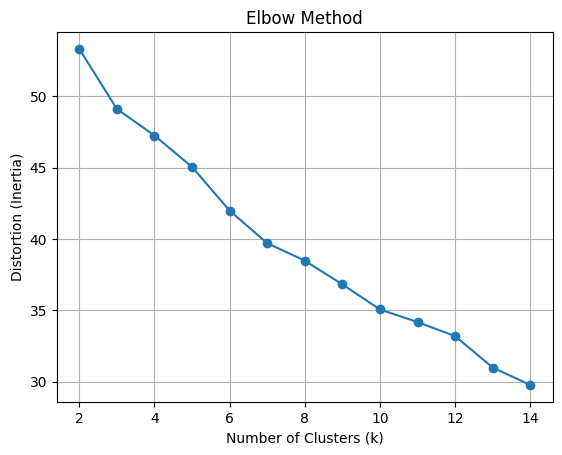

In [57]:
# STEP 5: find optimal number of clusters using the Elbow Method
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

distortions = []
K = range(2, 15)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(embeddings)
    distortions.append(kmeans.inertia_)

plt.plot(K, distortions, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Distortion (Inertia)')
plt.grid(True)
plt.show()


In [58]:
# The "Elbow Method" graph (plotted in cell above) helps to choose the optimal number of clusters (k) for KMeans.
# On the graph, the x-axis is the number of clusters (k), and the y-axis is the distortion (inertia).
# As k increases, distortion decreases. The "elbow" point is where the rate of decrease sharply slows down.
# Choose k at the elbow point, as adding more clusters beyond this gives diminishing returns.
# In your graph, look for the value of k where the curve bends ("elbow")—this is typically the optimal number of clusters.

In [59]:

# Based on the Elbow Method plot, the best value for k is typically chosen at the "elbow" point—where the distortion (inertia) starts to decrease more slowly as k increases. In the plot, this appears to be # around k=6 or 7, which is the value used for clustering.

In [60]:
# STEP 5: Cluster Embeddings (KMeans)
n_clusters = 6
print(f"Clustering into {n_clusters} groups...")
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df['semantic_cluster'] = kmeans.fit_predict(embeddings)

# STEP 6: Show Sample Summaries from Each Cluster
for cluster in range(n_clusters):
    print(f"\nCluster {cluster}")
    samples = df[df['semantic_cluster'] == cluster]['standardized_summary'].head(10)
    for i, summary in enumerate(samples):
        print(f"  {i+1}: {summary}")


Clustering into 6 groups...

Cluster 0
  1: rcd was tripped upon arrival and after resetting the csd was still off upon further investigation the fmps was faulty a storm recently hit the area fmps was replaced with mrn supplied parts services confirmed restored noc was also advised to send out sdp electrician to replace the rcd as the âtest trip buttonâ does not trip the circuit org person from noc advised and approved offsite
  2: on arrival found power to cardinal also found chattering fmps relay attempted to reset relay multiple times without success faulty fmps unit requires replacement
  3: cardinal to fmps no dc output csd required new fmps mrn is in notes as well mrn000188855 please assign to day crew going on stand down
  4: cardinal rectifier replaced silf and breaker checked and find no issues if issue persist will need to check the pdp by an norp tcs will also be monitoring and will coordinate with the electrician for further instructions incase another ticket is issued
  5:

In [61]:
# Check how semantic clusters align with manual categories
import pandas as pd
pd.crosstab(df['semantic_cluster'], df['Categorisation'])


Categorisation,AC Mains Issues (Electrician),CB Reset,DPU And Additional Equipment Replaced,DPU Replaced,DPU Replaced,FMPS Replaced,Faulty FMPS units causing power issues,Faulty FMPS units causing power issues (MRN Required),Rectifier Issue (Resolved),Replaced Battery,Tech Not Skilled,Temp Fix,Third Party Power
semantic_cluster,,,,,,,,,,,,,
0,12,0,0,0,2,6,2,7,2,0,0,0,4
1,0,0,0,0,0,0,0,0,0,17,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,12,0
3,0,1,2,2,0,0,0,1,0,0,0,4,0
4,0,1,0,0,0,0,0,0,0,0,2,0,0
5,0,0,0,0,0,0,0,0,0,17,0,0,0


In [62]:
label_vs_cluster = pd.crosstab(df['Categorisation'], df['semantic_cluster'])
print(label_vs_cluster)


semantic_cluster                                        0   1   2  3  4   5
Categorisation                                                             
AC Mains Issues (Electrician)                          12   0   0  0  0   0
CB Reset                                                0   0   0  1  1   0
DPU And Additional Equipment Replaced                   0   0   0  2  0   0
DPU Replaced                                            0   0   0  2  0   0
DPU Replaced                                            2   0   0  0  0   0
FMPS Replaced                                           6   0   0  0  0   0
Faulty FMPS units causing power issues                  2   0   0  0  0   0
Faulty FMPS units causing power issues (MRN Required)   7   0   0  1  0   0
Rectifier Issue (Resolved)                              2   0   0  0  0   0
Replaced Battery                                        0  17   0  0  0  17
Tech Not Skilled                                        0   0   0  0  2   0
Temp Fix    

In [63]:
def cluster_purity(df, label_col='Categorisation', cluster_col='semantic_cluster'):
    purity_report = []
    for label in df[label_col].dropna().unique():
        subset = df[df[label_col] == label]
        counts = subset[cluster_col].value_counts()
        majority_cluster = counts.idxmax()
        purity = counts.max() / counts.sum()
        purity_report.append({
            'Label': label,
            'Total Samples': counts.sum(),
            'Majority Cluster': majority_cluster,
            'Purity': round(purity, 2)
        })
    return pd.DataFrame(purity_report).sort_values(by='Purity', ascending=False)

# Run it
purity_df = cluster_purity(df)
print(purity_df)


                                                    Label  Total Samples  \
0                                          FMPS Replaced               6   
4                  Faulty FMPS units causing power issues              2   
3                                            DPU Replaced              2   
7                                           DPU Replaced               2   
5                              Rectifier Issue (Resolved)              2   
12                                      Tech Not Skilled               2   
11                                     Third Party Power               4   
8                   DPU And Additional Equipment Replaced              2   
9                           AC Mains Issues (Electrician)             12   
1   Faulty FMPS units causing power issues (MRN Required)              8   
2                                               Temp Fix              16   
6                                        Replaced Battery             34   
10          

Check how your semantic clusters align with manual categories

In [64]:
df['Categorisation'] = df['Categorisation'].astype(str).str.strip().str.lower()

In [65]:
df['Categorisation'] = df['Categorisation'].astype(str).str.strip()

In [66]:
cluster_num = 5  # cluster number
df[df['semantic_cluster'] == cluster_num][['standardized_summary', 'semantic_cluster']].to_csv(f"cluster_{cluster_num}_results.csv", index=False)

In [67]:
df[(df['Categorisation'] == 'temp fix') & (df['semantic_cluster'] == 2)][['standardized_summary']]

,standardized_summary
4,date cable damaged by lightning activityhaul new cardinal pr temporary to provide service and bagged joint do not need permanent fix as n2p is in the pits ready for cutover
5,date pr aerial cable damaged temporary repair mudmap submitted for permanent fix
6,quantity was damaged in cardinal locations within the person premises porsche collingwood by the civil crew doing new construction work for the customer the site manager was able to repair the lic and subsequently we have run a new sds with temp fix having cardinal gators on one at the pit outside premises and the other inside the building services are up and running confirmed with ee damaged caused by construction crew company minicon site manager person contact date damage form submitted with artefacts org nbnref
7,ordinal copper cable installed in between pits and temp fix done for permanent fix need civils the damage on cable looks like due to recent n2p activity cx modem in sync checked with noc team
9,cardinal fibres dug up by house owner putting fence in submitted ordinal party damage form sdp engaged to do temp fix
52,10040 cable damaged by lightning activityhaul new 10 pr temporary to provide service and bagged joint do not need permanent fix as n2p is in the pits ready for cutover
53,10040 pr aerial cable damaged temporary repair mudmap submitted for permanent fix
54,100mm org was damaged in two locations within the org premises org by the civil crew doing new construction work for the customer the site manager was able to repair the org and subsequently we have run a new org with temp fix having two gators on one at the pit outside premises and the other inside the building services are up and running confirmed with ee damaged caused by construction crew company minicon site manager person date damage form submitted with artefacts ref nbn02463431
55,10pr copper cable installed in between pits and temp fix done for permanent fix need civils the damage on cable looks like due to recent n2p activity cx modem in sync checked with noc team
57,2 fibres dug up by house owner putting fence in submitted 3rd party damage form org engaged to do temp fix


In [68]:
df[(df['Categorisation'] == 'temp fix') & (df['semantic_cluster'] == 5)][['standardized_summary']]

,standardized_summary


In [69]:
df[(df['Categorisation'] == 'faulty fmps units causing power issues (mrn required)') & (df['semantic_cluster'] == 1)][['standardized_summary']]

,standardized_summary


In [70]:
df[(df['Categorisation'] == 'faulty fmps units causing power issues (mrn required)') & (df['semantic_cluster'] == 3)][['standardized_summary']]

,standardized_summary
2,found that the fmps still had product but it was making a ticking a sound the output voltage was date i believe the fmps has failed and will need replacing


Example of Generating Embedding

In [71]:
from sentence_transformers import SentenceTransformer

# Load the model
model = SentenceTransformer("all-MiniLM-L6-v2")

# Your sample text
text = "RCD was tripped upon arrival, and after resetting the CSD was still off."

# Generate embedding
embedding = model.encode(text)

print(embedding)

[-3.32995132e-02  2.18326896e-02 -8.59158952e-03  3.34905982e-02
  1.14718281e-01  3.37168835e-02 -6.44990951e-02  5.14427125e-02
 -2.58690063e-02  1.90664083e-02  6.71328828e-02  4.51930985e-02
  6.43368140e-02  4.35840413e-02  1.14151658e-02 -2.26448476e-02
  1.05962185e-02 -6.44902214e-02 -5.13617434e-02  4.05700170e-02
 -9.01893526e-02  8.62373859e-02  5.49430307e-03  3.65554877e-02
  1.32596120e-02 -5.81307337e-03 -2.10994780e-02 -5.64503372e-02
  2.72369534e-02  4.56563719e-02 -2.46571433e-02  1.99878141e-02
 -2.47702803e-02 -8.80659930e-03  5.95237762e-02  3.38483825e-02
  6.64703250e-02 -7.67300604e-04 -1.99000016e-02  3.10754385e-02
 -5.05033601e-03  3.66351083e-02 -6.25872537e-02 -1.74464546e-02
  4.31644693e-02  5.07900789e-02  1.95440408e-02 -1.07407816e-01
  2.05265004e-02  2.12223828e-02  3.60639244e-02  5.05436212e-02
 -1.62719376e-02 -2.74885483e-02 -9.09539219e-03  3.92321013e-02
  3.25041339e-02 -2.84655299e-02  9.68953073e-02 -1.00757489e-02
 -3.97156551e-02 -7.02843